In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import sys

# reference main directory in existing folder
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import pandas as pd 
import sys
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from src.paths import RAW_DATA_DIR, CLEANED_DATA_DIR
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# show all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

# import data
#savant = pd.read_csv(RAW_DATA_DIR / 'savant_pitch_level.csv')
#data_dictionary = pd.read_excel(RAW_DATA_DIR / 'data_dictionary.xlsx')
#fangraph = pd.read_csv(RAW_DATA_DIR / 'fangraphs_season_level.csv')
fangraph = pd.read_csv(CLEANED_DATA_DIR / 'fangraphs_engineered_merged.csv')

In [2]:
# replace int and float columns nan with 0
int_cols = fangraph.select_dtypes(include=['int']).columns
float_cols = fangraph.select_dtypes(include=['float']).columns
fangraph[int_cols] = fangraph[int_cols].fillna(0)
fangraph[float_cols] = fangraph[float_cols].fillna(0)

In [3]:
# drop columns rows with nan values
fangraph = fangraph.dropna()

In [4]:
df_clean = fangraph.copy()

In [5]:
# Move all string columns next to each other
string_columns = df_clean.select_dtypes(include=['object']).columns
other_columns = [col for col in df_clean.columns if col not in string_columns]

# Reorder the columns by first placing string columns and then other columns
df_clean = df_clean[string_columns.tolist() + other_columns]

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

features = df_clean.columns[10:]
x = df_clean.loc[:, features].values

# standardizing the features
x = StandardScaler().fit_transform(x)

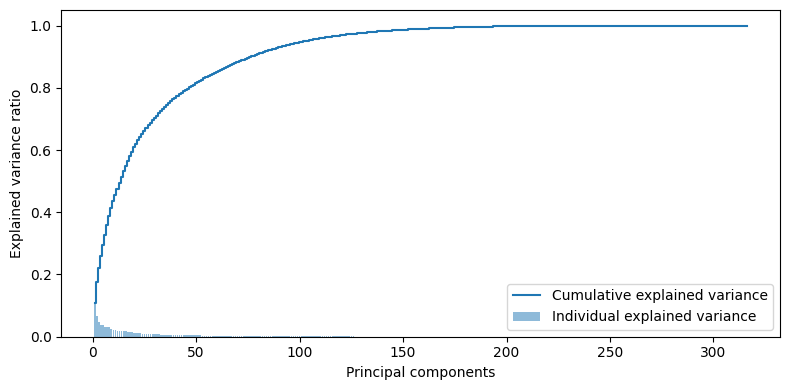

In [7]:
# determine the # of PCA we should use
pca = PCA(n_components=len(features))
principalComponents = pca.fit_transform(x)

# Cumulative explained variance
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

# Plotting
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(features) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(features) + 1), cumulative_explained_variance, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


##### PCA 50 can explain 80% of the variance
##### Imagine we have a large box full of different colored crayons—so many that it's hard to decide which ones to use for our picture. Now, think of a chart that shows us which crayons are the best at helping us create a beautiful picture. Each bar on the chart is like a helper showing how much it can contribute to our artwork. Some helpers are superstars and tell us a lot, while others don't add much to our picture. The rising line on the chart is like a ladder, showing how our picture gets better and better as we add more superstar helpers. But, as we climb higher, we notice that adding more helpers doesn't really make our picture much better. This chart is a special tool that helps us pick just the right number of crayons to make our picture pretty without using every single color in the box. It tells us that if we choose about 40 to 50 of these special helpers, our picture will turn out just right, without any extra fuss!

In [8]:
# Performing PCA
pca = PCA(n_components=2) # You can change the number of components
principalComponents = pca.fit_transform(x)

In [9]:
# Creating a DataFrame with principal components

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [11]:
df_clean = df_clean.reset_index(drop=True)
principalDf['classified_role'] = df_clean['classified_role'] 
principalDf['Name'] = df_clean['Name'] 

In [12]:
principalDf.isnull().sum()

principal component 1    0
principal component 2    0
classified_role          0
Name                     0
dtype: int64

In [13]:
principalDf['classified_role'].unique()

array(['Setup Pitcher', 'Middle Reliever', 'Closer', 'Long Reliever',
       'Starting Pitcher'], dtype=object)

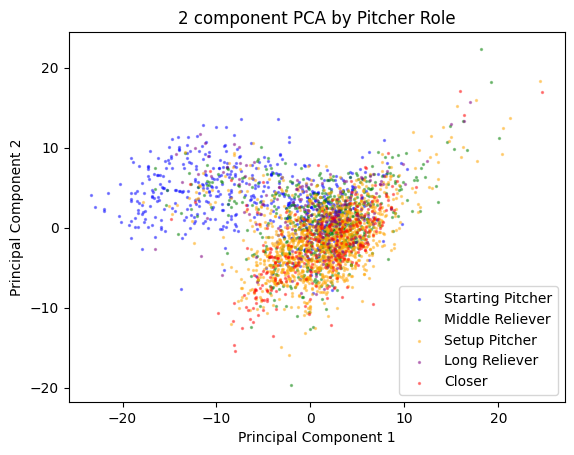

In [14]:
# Visualizing the PCA results
# 'Middle Reliever', 'SP', 'Setup Man', 'Other Relief', 'Closer'
plt.figure()
for Role, color in [('Starting Pitcher', 'blue'), 
                    ('Middle Reliever', 'green'),
                    ('Setup Pitcher', 'orange'),
                    ('Long Reliever', 'purple'),
                    ('Closer','red')]:  
    indicesToKeep = principalDf['classified_role'] == Role
    plt.scatter(principalDf.loc[indicesToKeep, 'principal component 1'],
                principalDf.loc[indicesToKeep, 'principal component 2'],
                c=color,
                s=2,
                alpha = 0.4,
                label=Role)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 component PCA by Pitcher Role')
plt.legend()
plt.show()

### we can tell that there are 2 cluster, SP and RP are each belonging to different cluster # some SP fall into RP cluster and some RP fall into SP cluster could suggest role switching but further analysis should be conducted

In [15]:
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import iplot

# Create a figure with specified layout size
fig = go.Figure(layout=go.Layout(
    title='2 component PCA by Pitcher Role with Feature Loadings',
    xaxis_title='Principal Component 1',
    yaxis_title='Principal Component 2',
    legend_title='Role',
    hovermode='closest',
    width=1000,  # Width of the figure in pixels
    height=800   # Height of the figure in pixels
))

for Role, color in [('Starting Pitcher', 'blue'), 
                    ('Middle Reliever', 'green'),
                    ('Setup Pitcher', 'orange'),
                    ('Long Reliever', 'purple'),
                    ('Closer','red')]:   # Adjust roles and colors as needed
    indicesToKeep = principalDf['classified_role'] == Role
    fig.add_trace(go.Scattergl(
        x=principalDf.loc[indicesToKeep, 'principal component 1'],
        y=principalDf.loc[indicesToKeep, 'principal component 2'],
        mode='markers',
        marker=dict(color=color, size=5, opacity=0.4),  # Adjust the size of the dots here
        name=Role,
        text=principalDf.loc[indicesToKeep, 'Name']  # Assuming you have player names in the 'Player' column
    ))
# Add feature loadings as arrows
for i, feature in enumerate(features):
    fig.add_trace(go.Scatter(
        x=[0, pca.components_[0, i] * 230],  # X start and end positions for arrow
        y=[0, pca.components_[1, i] * 230],  # Y start and end positions for arrow
        mode='lines+text',
        text=[None, feature],  # Only label the end of the arrow
        textposition="bottom center",
        line=dict(color='grey', width=0.2),
        showlegend=False
    ))

# Show the figure
iplot(fig)


In [16]:
principalDf.head()

,principal component 1,principal component 2,classified_role,Name
0,4.918272,-0.979428,Setup Pitcher,NeftalA­ Feliz
1,2.597973,0.957054,Middle Reliever,Tommy Hunter
2,3.972255,-3.859510,Setup Pitcher,Matt Bush
3,-4.906414,-3.998125,Setup Pitcher,Adam Ottavino
4,0.663280,-1.440607,Setup Pitcher,Zack Greinke


In [17]:
import pandas as pd

# Assuming 'principalDf' is your principal components DataFrame
# First, we'll define the quadrants based on the principal components
def define_quadrant(row):
    if row['principal component 1'] >= 0 and row['principal component 2'] >= 0:
        return 'Quadrant 1'
    elif row['principal component 1'] < 0 and row['principal component 2'] >= 0:
        return 'Quadrant 2'
    elif row['principal component 1'] < 0 and row['principal component 2'] < 0:
        return 'Quadrant 3'
    else:
        return 'Quadrant 4'
    
principalDf['Quadrant'] = principalDf.apply(define_quadrant, axis=1)

# Next, we'll create a pivot table to calculate the counts of roles in each quadrant
pivot_table = principalDf.pivot_table(index='Quadrant', columns='classified_role', aggfunc='size', fill_value=0)

# Calculate the percentages of each role in each quadrant
quadrant_role_percentages = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100


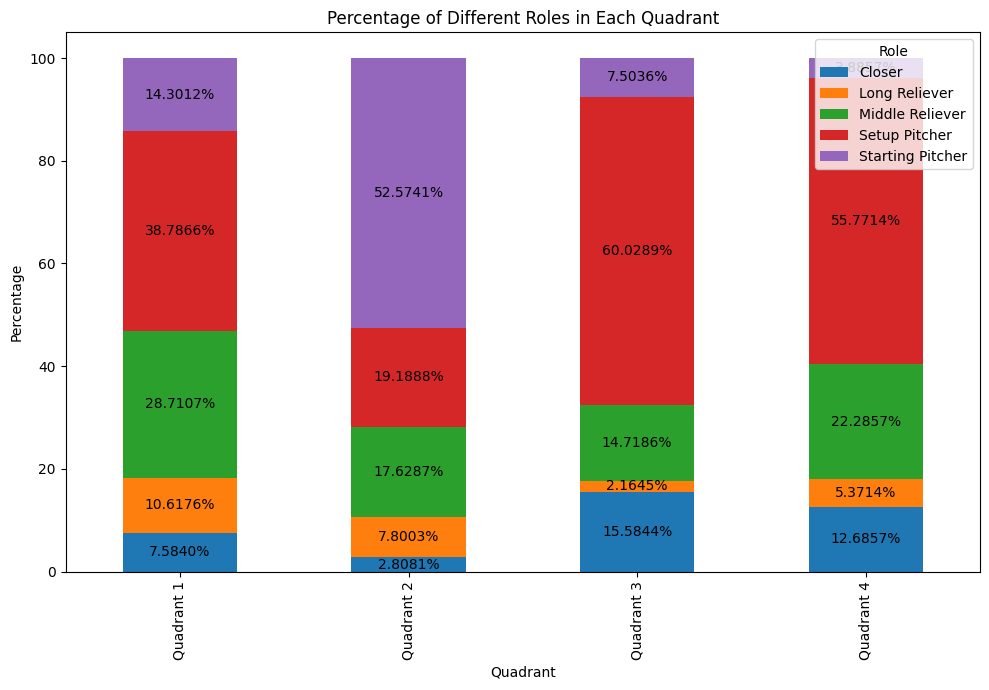

In [18]:
# Plot the stacked bar chart and capture the returned axes
ax = quadrant_role_percentages.plot(kind='bar', stacked=True, figsize=(10, 7))

# Add labels and title
ax.set_xlabel('Quadrant')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Different Roles in Each Quadrant')
ax.legend(title='Role')

# Adding percentage text on each bar
for bars in ax.containers:
    ax.bar_label(bars, fmt='%.4f%%', label_type='center')

# Show the plot
plt.tight_layout()
plt.show()

### Save the feature loadings to a DataFrame

In [19]:
# Assuming pca is your PCA object and features is the list of feature names
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)

# Calculate the distance of each loading from the origin
loadings['Distance'] = np.sqrt(loadings['PC1']**2 + loadings['PC2']**2)

# Function to determine the quadrant
def determine_quadrant(row):
    if row['PC1'] >= 0 and row['PC2'] >= 0:
        return 'Q1'
    elif row['PC1'] < 0 and row['PC2'] >= 0:
        return 'Q2'
    elif row['PC1'] < 0 and row['PC2'] < 0:
        return 'Q3'
    elif row['PC1'] >= 0 and row['PC2'] < 0:
        return 'Q4'
    
# Apply the function to the DataFrame to create a new 'Quadrant' column
loadings['Quadrant'] = loadings.apply(determine_quadrant, axis=1)

# Create DataFrames for each quadrant
quadrants = {}
for quadrant in ['Q1', 'Q2', 'Q3', 'Q4']:
    quadrants[quadrant] = loadings[loadings['Quadrant'] == quadrant].sort_values('Distance', ascending=False)


In [20]:
from src.desc import baseball_stats_definitions

# map the stat names to the definitions
quadrants['Q1']['Stat'] = quadrants['Q1'].index.map(baseball_stats_definitions)
quadrants['Q2']['Stat'] = quadrants['Q2'].index.map(baseball_stats_definitions)
quadrants['Q3']['Stat'] = quadrants['Q3'].index.map(baseball_stats_definitions)
quadrants['Q4']['Stat'] = quadrants['Q4'].index.map(baseball_stats_definitions)

# Look at quadrant 
quadrant1 = quadrants['Q1'] # Low RP and SP
quadrant2 = quadrants['Q2'] # High SP and Low RP
quadrant3 = quadrants['Q3'] # High RP and Low SP
quadrant4 = quadrants['Q4'] # Low SP and High RP

In [21]:
principalDf.dropna(inplace=True)
principalDf.Name.isnull().sum()

0

In [22]:
# get player names for each quadrant
q1 = principalDf[principalDf.Quadrant == 'Q1']
q2 = principalDf[principalDf.Quadrant == 'Q2']
q3 = principalDf[principalDf.Quadrant == 'Q3']
q4 = principalDf[principalDf.Quadrant == 'Q4']

In [23]:
from src.paths import QUADRANT_DATA_DIR
# Save the quadrants data to xlsx file 
quadrant1.to_excel(QUADRANT_DATA_DIR / 'quadrant1_SP_RP_EQUAL.xlsx')
quadrant2.to_excel(QUADRANT_DATA_DIR / 'quadrant2_SP_MAJORITY.xlsx')
quadrant3.to_excel(QUADRANT_DATA_DIR / 'quadrant3_RP_MAJORITY.xlsx')
quadrant4.to_excel(QUADRANT_DATA_DIR / 'quadrant4_RP_MAJORITY.xlsx')

# Save the players in each quadrant to xlsx file
q1.to_excel(QUADRANT_DATA_DIR / 'q1_players.xlsx')
q2.to_excel(QUADRANT_DATA_DIR / 'q2_players.xlsx')
q3.to_excel(QUADRANT_DATA_DIR / 'q3_players.xlsx')
q4.to_excel(QUADRANT_DATA_DIR / 'q4_players.xlsx')

# Save the principalDF
principalDf.to_excel(QUADRANT_DATA_DIR / 'principalDf.xlsx')
